In [81]:
#by Willkie
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from datetime import datetime

warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [47]:
import re
import pandas as pd
from datetime import datetime

# Job dictionary and spec ranges
job_dict = {
    "허": "허밋", "시": "시프", "썬": "썬콜", "불독": "불독",
    "프": "프리스트", "레": "레인저", "저": "저격수",
    "용": "용기사", "크": "크루세이더", "나": "나이트"
}
job_spec_ranges = {
    "용": (3000, 6000), "크": (2000, 6000), "나": (2000, 6000),
    "허": (1500, 3500), "시": (1500, 3500), "썬": (500, 1000),
    "불독": (500, 1000), "프": (500, 1000), "레": (2000, 4000),
    "저": (2000, 4000)
}
level_min, level_max = 80, 200

# Regex patterns
time_pattern = r"(오전|오후) \d{1,2}:\d{2}"
job_pattern = r"(\d{2,3})\s?(" + "|".join(job_dict.keys()) + r")"
spec_pattern = r"(\d{3,4})"
map_pattern = r"(망용둥|위용둥|와협|불와둥|협동|레와둥|붉켄|검켄|푸켄|불어전|물어전|오징어|망둥어|듀파|갈림길|골짜기)"

def extract_level_and_spec(text, job_match_end, level_range, spec_range):
    numbers = [(int(x), match.start()) for match in re.finditer(r"\b\d{2,4}\b", text) for x in [match.group()]]
    level, spec = None, None
    for num, position in numbers:
        if level is None and level_range[0] <= num <= level_range[1]:
            level = num
        elif spec is None and spec_range[0] <= num <= spec_range[1]:
            spec = num
    if level and spec and level == spec:
        spec = None
    return level, spec

def collect_initial_data(file_path):
    columns = ["party_id", "time", "level", "job", "spec", "map", "date", "valid"]
    df = pd.DataFrame(columns=columns)

    # Format date as "2024-12-09"
    month = file_path[-8:-6]
    day = file_path[-6:-4]
    date_from_file = f"2024-{month}-{day}"
    
    party_id = 0
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    blocks = data.split("오늘")
    for block in blocks[1:]:
        time_match = re.search(time_pattern, block)
        time = time_match.group(0) if time_match else None
        map_match = re.search(map_pattern, block)
        map_name = map_match.group(0) if map_match else None
        job_matches = re.finditer(job_pattern, block)
        for job_match in job_matches:
            job_short = job_match.group(2)
            job_full = job_dict.get(job_short, "Unknown")
            spec_search_area = block[job_match.end():]
            level, spec = extract_level_and_spec(spec_search_area, job_match.end(), (level_min, level_max), job_spec_ranges.get(job_short, (None, None)))
            valid = spec is not None and level is not None
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "party_id": party_id,
                    "time": time,
                    "level": level,
                    "job": job_full,
                    "spec": spec,
                    "map": map_name,
                    "date": date_from_file,
                    "valid": valid
                }])
            ], ignore_index=True)
        party_id += 1
    df = df.drop_duplicates(subset=["party_id", "level", "job", "spec"])
    df = df.drop_duplicates(subset=["level", "job", "spec"])
    output_file = file_path.replace('.txt', '.csv')
    df.to_csv(output_file, index=False)
    return df

def reprocess_data(df, file_path):
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    valid_df = df[(df["valid"] == True) & (df["spec_to_level"].notna())]
    average_ratios = valid_df.groupby("job")["spec_to_level"].mean().reset_index()
    average_ratios.rename(columns={"spec_to_level": "average_spec_to_level"}, inplace=True)
    df = df.merge(average_ratios, on="job", how="left")
    df = df[
        (df["spec_to_level"] >= 0.8 * df["average_spec_to_level"]) & 
        (df["spec_to_level"] <= 1.2 * df["average_spec_to_level"])
    ]
    refined_valid_df = df[(df["valid"] == True) & (df["spec_to_level"].notna())]
    refined_average_ratios = refined_valid_df.groupby("job")["spec_to_level"].mean().reset_index()
    refined_average_ratios.rename(columns={"spec_to_level": "refined_average_spec_to_level"}, inplace=True)
    df = df.merge(refined_average_ratios, on="job", how="left")
    refined_output_file = file_path.replace('.txt', '_processed.csv')
    df.to_csv(refined_output_file, index=False)
    return df

def process_files(file_paths):
    combined_df = pd.DataFrame()
    combined_processed_df = pd.DataFrame()
    for file_path in file_paths:
        df = collect_initial_data(file_path)
        processed_df = reprocess_data(df, file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
        combined_processed_df = pd.concat([combined_processed_df, processed_df], ignore_index=True)
    combined_df.to_csv("df.csv", index=False)
    combined_processed_df.to_csv("df_processed.csv", index=False)

# List of file paths
file_paths = ["1207.txt", "1208.txt", "1209.txt", "1210.txt"]
process_files(file_paths)


In [63]:
df = pd.read_csv("df.csv")
df

,party_id,time,level,job,spec,map,date,valid,spec_to_level
0,0,오후 3:40,NaN,썬콜,NaN,불어전,2024-12-07,False,NaN
1,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,NaN
2,4,오후 3:30,NaN,허밋,NaN,붉켄,2024-12-07,False,NaN
3,5,오후 3:31,NaN,허밋,2109.0,NaN,2024-12-07,False,NaN
4,6,오후 3:31,117.0,레인저,2950.0,오징어,2024-12-07,True,25.213675
...,...,...,...,...,...,...,...,...,...
948,196,오전 12:13,NaN,불독,NaN,협동,2024-12-10,False,NaN
949,197,오전 12:13,135.0,프리스트,835.0,NaN,2024-12-10,True,6.185185
950,198,오전 12:13,138.0,용기사,NaN,골짜기,2024-12-10,False,NaN
951,198,오전 12:13,109.0,썬콜,NaN,골짜기,2024-12-10,False,NaN


In [64]:
df_processed = pd.read_csv("df_processed.csv")
df_processed

,party_id,time,level,job,spec,map,date,valid,spec_to_level,average_spec_to_level,refined_average_spec_to_level
0,6,오후 3:31,117,레인저,2950,오징어,2024-12-07,True,25.213675,23.315265,22.907384
1,6,오후 3:31,117,크루세이더,3696,오징어,2024-12-07,True,31.589744,33.446903,34.013278
2,6,오후 3:31,127,허밋,2096,오징어,2024-12-07,True,16.503937,20.539495,19.215424
3,6,오후 3:31,109,허밋,2300,오징어,2024-12-07,True,21.100917,20.539495,19.215424
4,18,오후 3:31,149,프리스트,910,불어전,2024-12-07,True,6.107383,6.215400,6.215400
...,...,...,...,...,...,...,...,...,...,...,...
152,140,오전 12:10,120,썬콜,720,불어전,2024-12-10,True,6.000000,6.692917,6.365301
153,140,오전 12:10,112,허밋,2200,불어전,2024-12-10,True,19.642857,20.984848,18.750000
154,168,오전 12:11,126,크루세이더,4181,협동,2024-12-10,True,33.182540,31.592703,34.227721
155,180,오전 12:12,158,프리스트,971,불어전,2024-12-10,True,6.145570,6.359031,6.359031


In [65]:
hermit = df[(df['job'] == '허밋')]
hermit
hermit_vaild = hermit[hermit['valid'] == True]
hermit_vaild

,party_id,time,level,job,spec,map,date,valid,spec_to_level
6,6,오후 3:31,127.0,허밋,2096.0,오징어,2024-12-07,True,16.503937
7,6,오후 3:31,109.0,허밋,2300.0,오징어,2024-12-07,True,21.100917
30,27,오후 3:32,84.0,허밋,2800.0,듀파,2024-12-07,True,33.333333
44,35,오후 3:32,126.0,허밋,1900.0,오징어,2024-12-07,True,15.079365
111,150,오후 3:41,104.0,허밋,1870.0,NaN,2024-12-07,True,17.980769
123,180,오후 3:41,103.0,허밋,2164.0,오징어,2024-12-07,True,21.009709
135,203,오후 8:14,104.0,허밋,2680.0,NaN,2024-12-07,True,25.769231
151,220,오후 8:15,118.0,허밋,1800.0,푸켄,2024-12-07,True,15.254237
177,254,오후 8:16,123.0,허밋,2587.0,망둥어,2024-12-07,True,21.032520
249,366,오후 10:52,97.0,허밋,1600.0,듀파,2024-12-07,True,16.494845


In [66]:
unique_maps = df["map"].unique()
print("Maps in the data:")
for map_name in unique_maps:
    print(map_name)

Maps in the data:
불어전
붉켄
nan
오징어
듀파
망용둥
망둥어
위용둥
레와둥
푸켄
협동
골짜기
와협
검켄
갈림길
물어전


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   party_id       953 non-null    int64  
 1   time           953 non-null    object 
 2   level          741 non-null    float64
 3   job            953 non-null    object 
 4   spec           357 non-null    float64
 5   map            759 non-null    object 
 6   date           953 non-null    object 
 7   valid          953 non-null    bool   
 8   spec_to_level  185 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 60.6+ KB
None

Data Overview:
   party_id     time  level   job    spec  map        date  valid  \
0         0  오후 3:40    NaN    썬콜     NaN  불어전  2024-12-07  False   
1         0  오후 3:40    NaN  프리스트     NaN  불어전  2024-12-07  False   
2         4  오후 3:30    NaN    허밋     NaN   붉켄  2024-12-07  False   
3         5  오후 3:31    NaN    

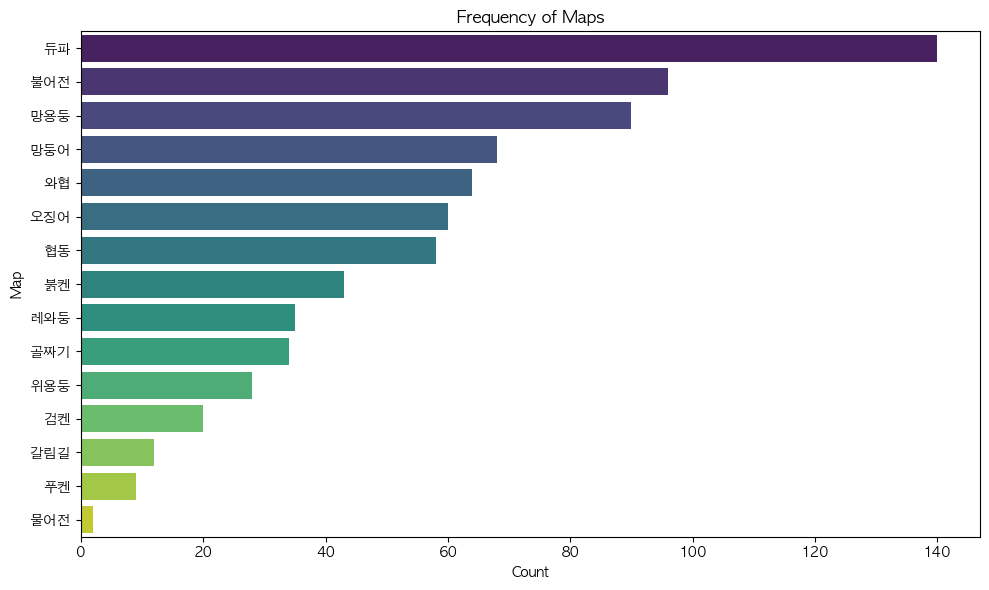

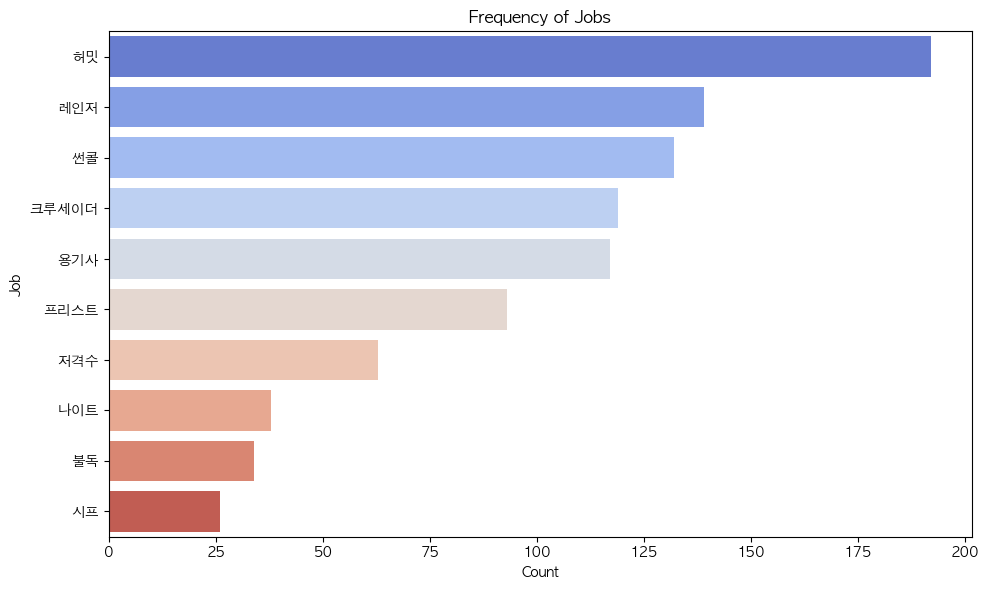

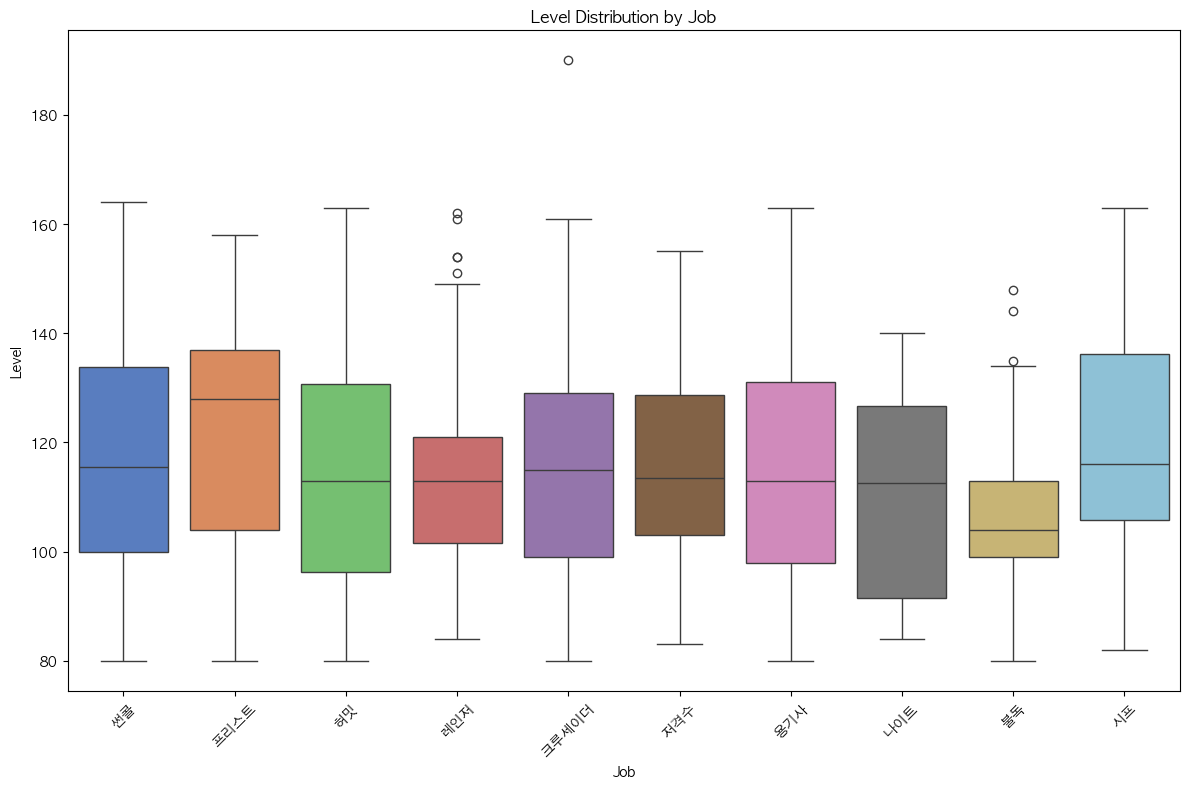

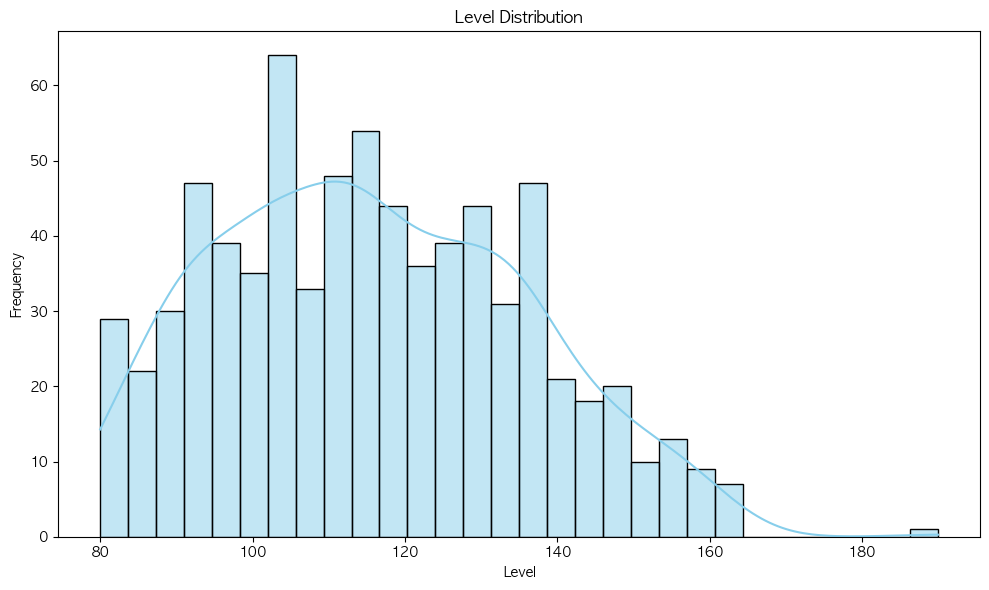

In [67]:
# Display basic information about the DataFrame
print("Basic Info:")
print(df.info())

print("\nData Overview:")
print(df.head())

# Count frequency of maps
map_counts = df["map"].value_counts()

print("\nMap Frequency:")
print(map_counts)

# Count frequency of jobs
job_counts = df["job"].value_counts()

print("\nJob Frequency:")
print(job_counts)

# Distribution of levels by job
print("\nLevel Statistics by Job:")
print(df.groupby("job")["level"].describe())

# Convert 'level' column to numeric for analysis
df["level"] = pd.to_numeric(df["level"], errors="coerce")

# 1. Map Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y="map", data=df, order=map_counts.index, palette="viridis")
plt.title("Frequency of Maps")
plt.xlabel("Count")
plt.ylabel("Map")
plt.tight_layout()
plt.show()

# 2. Job Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y="job", data=df, order=job_counts.index, palette="coolwarm")
plt.title("Frequency of Jobs")
plt.xlabel("Count")
plt.ylabel("Job")
plt.tight_layout()
plt.show()

# 3. Level Distribution by Job
plt.figure(figsize=(12, 8))
sns.boxplot(x="job", y="level", data=df, palette="muted")
plt.title("Level Distribution by Job")
plt.xlabel("Job")
plt.ylabel("Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Level Distribution Overall
plt.figure(figsize=(10, 6))
sns.histplot(df["level"], kde=True, bins=30, color="skyblue")
plt.title("Level Distribution")
plt.xlabel("Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


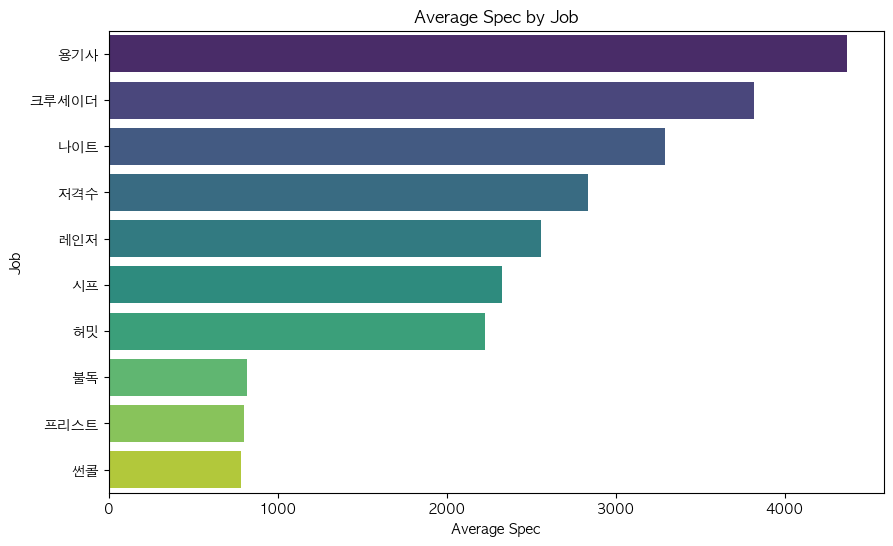

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
df['spec'] = pd.to_numeric(df['spec'], errors='coerce')

# Calculate the average spec by job, ignoring NaN values
average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()

# Fill NaN values with 0 for jobs with no spec data
average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)

# Ensure all jobs are represented, even if they have no spec data
all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]

# Create a DataFrame for missing jobs with spec value set to 0
missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})

# Concatenate the missing jobs DataFrame with the existing DataFrame
average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)

# Sort the data for better visualization
average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)

# Set up the visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')

# Add labels and title
plt.xlabel('Average Spec')
plt.ylabel('Job')
plt.title('Average Spec by Job')

# Display the plot
plt.show()


In [69]:
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("Job Frequency by Map")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [76]:
def plot_level_spec_by_job(df, job):
    hermit_df = df[df["job"] == job]
    
    # Plot Level vs Spec for Hermit without including map
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=hermit_df, x="level", y="spec", s=100)
    plt.title("Hermit's Level vs Spec")
    plt.xlabel("Level")
    plt.ylabel("Spec")
    plt.show()

In [78]:
def plot_level_by_map_by_job(df, job):
    hermit_df = df[df["job"] == job]
    
    # Plot Level by Map for Hermit
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=hermit_df, x="map", y="level", palette="Set2")
    plt.title("Hermit's Level by Map")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.show()

In [72]:
def plot_spec_to_level_ratio_by_job(df):
    # Compute the spec-to-level ratio
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    
    # Plot spec-to-level ratio by job
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="job", y="spec_to_level", palette="Set3")
    plt.title("Spec-to-Level Ratio by Job")
    plt.xlabel("Job")
    plt.ylabel("Spec-to-Level Ratio")
    plt.xticks(rotation=45)
    plt.show()


In [73]:
def plot_level_distribution_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x="level", hue="job", multiple="stack", bins=20, palette="Set2")
    plt.title("Distribution of Levels by Job")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.show()


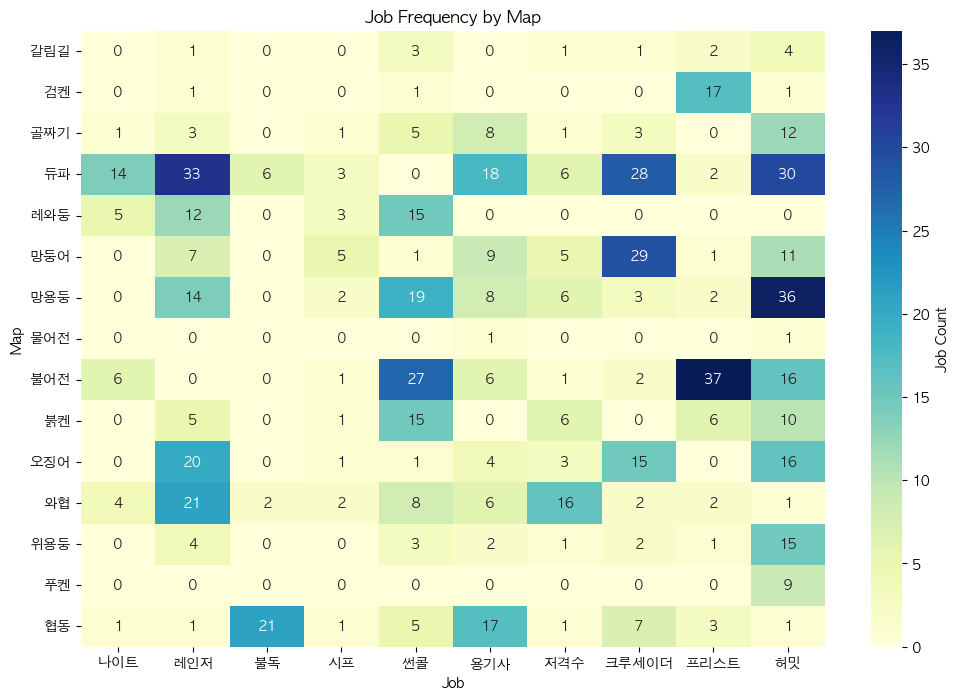

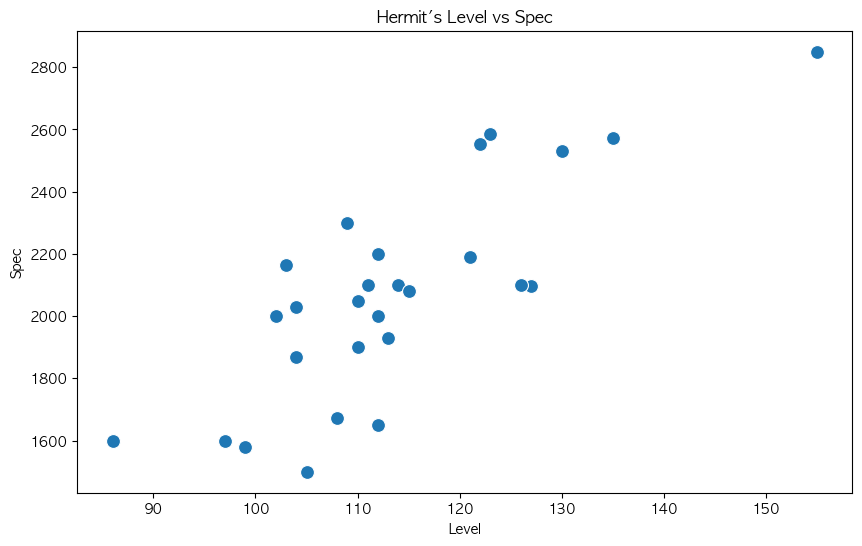

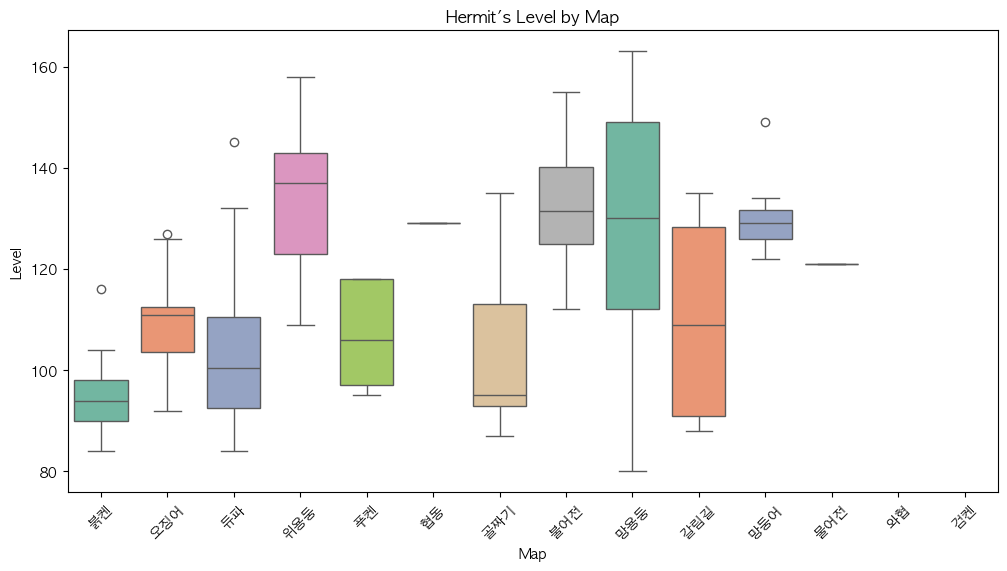

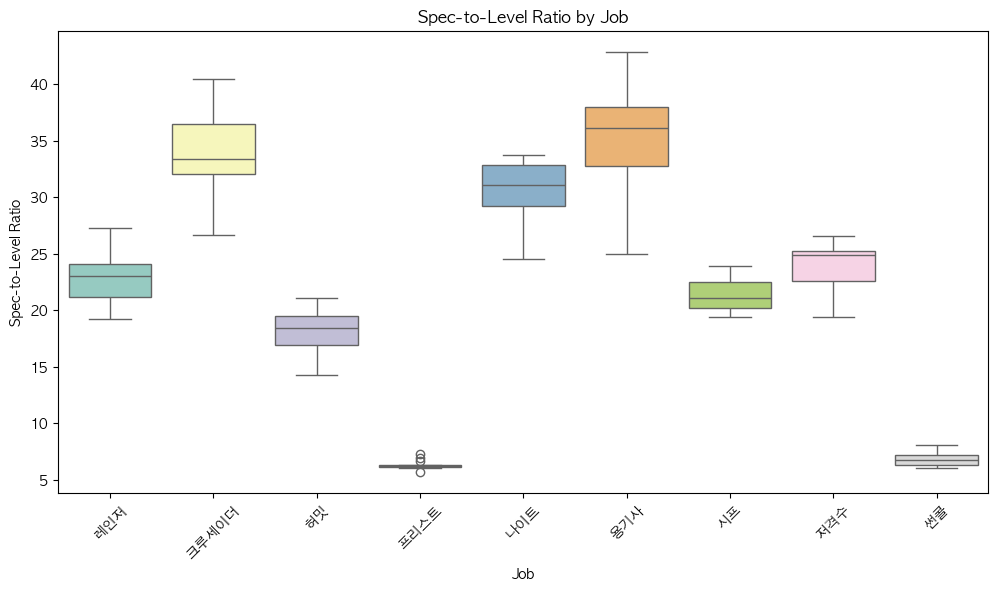

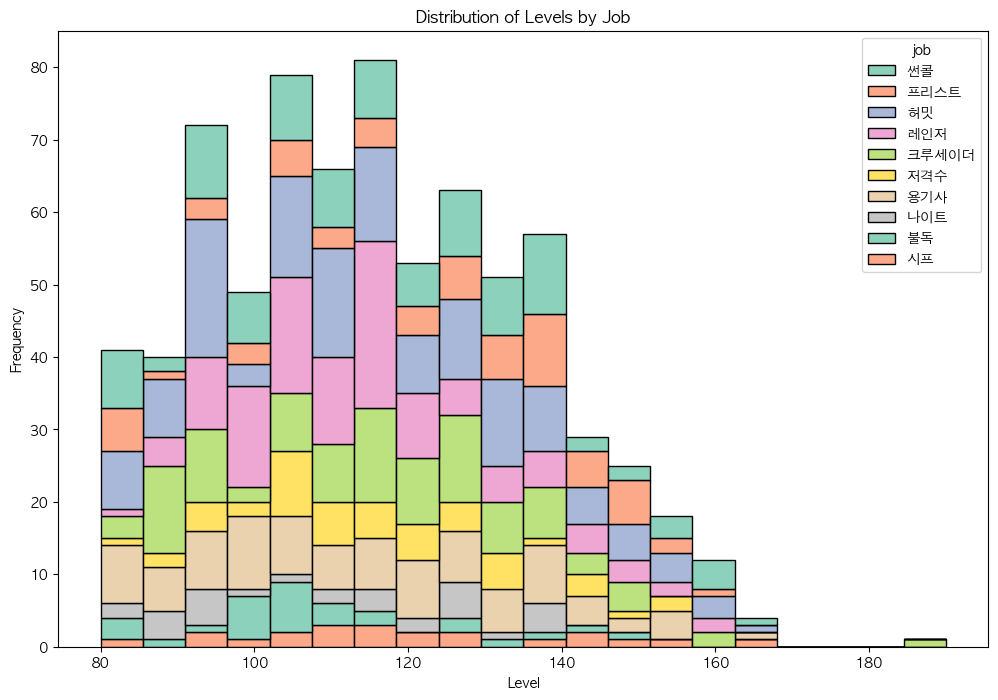

In [80]:
# Assuming `df` is your processed DataFrame
plot_job_frequency_by_map(df)
plot_level_spec_by_job(df_processed, "허밋")
plot_level_by_map_by_job(df, "허밋")
plot_spec_to_level_ratio_by_job(df_processed)
plot_level_distribution_by_job(df)

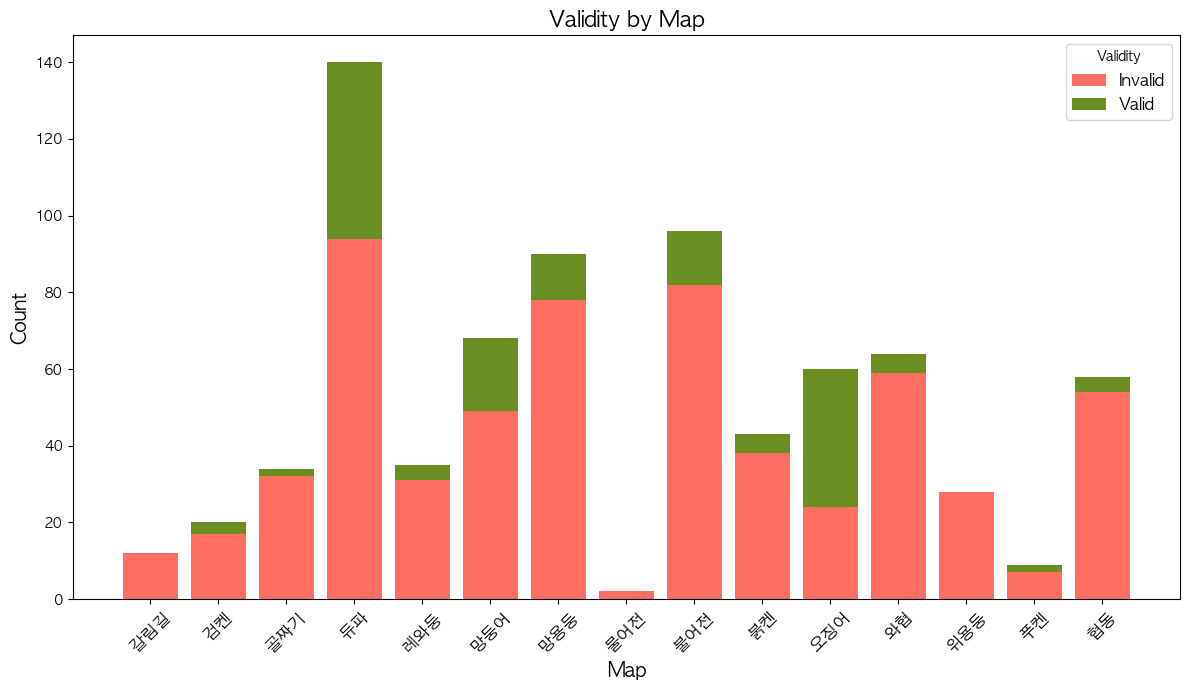

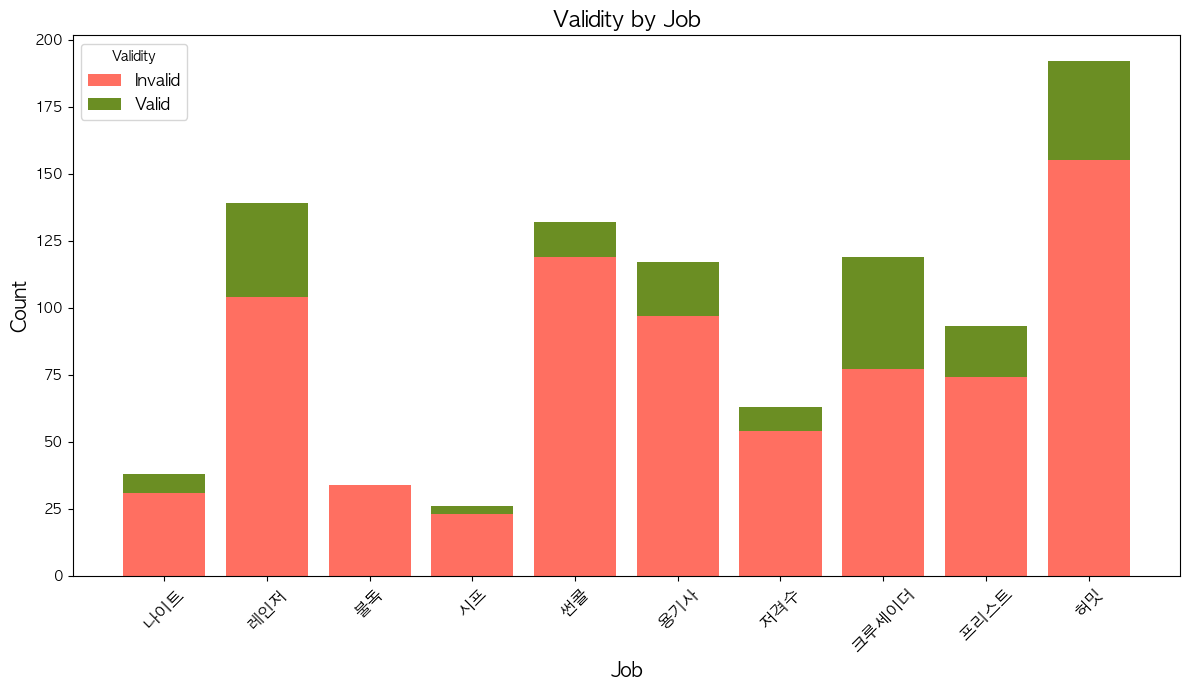

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_validity_by_map(df):
    """
    Visualizes the validity of the data by map using Seaborn with stacked bars.
    """
    # Count valid and invalid entries for each map
    validity_by_map = df.groupby(['map', 'valid']).size().unstack(fill_value=0)
    
    # Normalize index for plotting
    validity_by_map = validity_by_map.reset_index()
    
    # Set up figure
    plt.figure(figsize=(12, 7))
    
    # Plot stacked bars
    plt.bar(validity_by_map['map'], validity_by_map[0], label='Invalid', color='#FF6F61')
    plt.bar(validity_by_map['map'], validity_by_map[1], bottom=validity_by_map[0], label='Valid', color='#6B8E23')
    
    # Customize plot
    plt.title('Validity by Map', fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Validity', fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_validity_by_job(df):
    """
    Visualizes the validity of the data by job using Seaborn with stacked bars.
    """
    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid']).size().unstack(fill_value=0)
    
    # Normalize index for plotting
    validity_by_job = validity_by_job.reset_index()
    
    # Set up figure
    plt.figure(figsize=(12, 7))
    
    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='Invalid', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='Valid', color='#6B8E23')
    
    # Customize plot
    plt.title('Validity by Job', fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Validity', fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_validity_by_map(df)
visualize_validity_by_job(df)


In [82]:
#by Willkie